In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
import matplotlib
import matplotlib.pyplot as plt
!pip install -U matplotlib

Mounted at /content/gdrive
     |████████████████████████████████| 10.3 MB 14.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# !pip install ipympl

# %matplotlib notebook

In [ ]:
content_path = "/content/gdrive/MyDrive/DataScienceinCellImaging"
results_path = "/content/gdrive/MyDrive/DataScienceinCellImaging/results"

#Preprocess

Load Metadata and fill NaN

In [ ]:
metadata_df = pd.read_csv(content_path + '/metadata.csv')
metadata_df.drop(["well_id",	"experiment","plate",	"well", "site", "SMILES"],axis=1, inplace=True)
#dropping sites with  unknown disease condition
metadata_df['disease_condition'] = metadata_df[metadata_df['disease_condition'].notna()]
#NaN treatments are regarded as untreated
metadata_df["treatment_conc"] = metadata_df["treatment_conc"].fillna(0)
metadata_df["treatment"] = metadata_df["treatment"].fillna("untreated")
metadata_df

,site_id,cell_type,disease_condition,treatment,treatment_conc
0,HRCE-1_1_AA02_1,HRCE,Active SARS-CoV-2,Flubendazole,0.1
1,HRCE-1_1_AA02_2,HRCE,Active SARS-CoV-2,Flubendazole,0.1
2,HRCE-1_1_AA02_3,HRCE,Active SARS-CoV-2,Flubendazole,0.1
3,HRCE-1_1_AA02_4,HRCE,Active SARS-CoV-2,Flubendazole,0.1
4,HRCE-1_1_AA03_1,HRCE,Active SARS-CoV-2,acetylcysteine,1.0
...,...,...,...,...,...
305515,VERO-2_2_Z46_4,VERO,Active SARS-CoV-2,Lopinavir,1.0
305516,VERO-2_2_Z47_1,VERO,Active SARS-CoV-2,untreated,0.0
305517,VERO-2_2_Z47_2,VERO,Active SARS-CoV-2,untreated,0.0
305518,VERO-2_2_Z47_3,VERO,Active SARS-CoV-2,untreated,0.0


Load Embeddings

In [ ]:
embeddings_df = pd.read_csv(content_path + '/embeddings.csv')
embeddings_df

,site_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,...,feature_984,feature_985,feature_986,feature_987,feature_988,feature_989,feature_990,feature_991,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999,feature_1000,feature_1001,feature_1002,feature_1003,feature_1004,feature_1005,feature_1006,feature_1007,feature_1008,feature_1009,feature_1010,feature_1011,feature_1012,feature_1013,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
0,HRCE-1_10_AA02_1,2.355969,-0.058361,-0.169764,-0.316499,-0.891334,0.581174,-0.284587,-0.279198,-0.146575,-0.175336,-2.455430,-0.139774,-0.337087,1.628435,-0.713946,-0.932534,0.004243,0.066700,-0.101360,0.650752,-0.228591,0.161721,0.321429,0.033850,-2.137448,0.324023,0.473495,-1.583087,0.630035,1.167235,1.016468,0.114833,-1.614943,0.331538,-1.773885,0.291819,-1.851311,0.574511,-0.838225,...,1.142032,-0.845352,0.093382,0.408323,0.577964,0.056492,-0.219693,0.079488,-0.913954,-0.192929,-0.552265,-0.729298,0.322046,0.579591,0.270873,-0.388906,0.919923,0.836804,0.682457,0.297119,0.889674,0.322521,-1.069520,-0.178079,-0.726639,1.354043,0.130381,0.653186,-1.811593,0.995635,0.391186,0.786199,-1.739626,-1.317543,-1.208275,-0.507439,-0.317298,0.285018,-0.091285,-1.553895
1,HRCE-1_10_AA02_2,2.325652,-0.202519,-0.296017,-0.481136,-0.641461,0.702847,0.334191,-0.077498,-0.314538,-0.589848,-2.490217,-0.181231,-0.039784,1.365379,-0.750164,-1.118595,-0.030332,0.001164,-0.168584,0.268857,-0.261462,0.295830,0.098757,-0.273157,-2.191125,0.589241,0.675539,-1.377484,0.503110,1.232063,0.877188,0.037731,-2.015882,0.613051,-1.571816,-0.006229,-1.887402,0.774825,-1.143123,...,1.235851,-0.709567,-0.188990,0.115479,0.347220,-0.160982,-0.243853,0.115886,-0.902359,-0.540325,-0.541267,-0.400601,0.199344,0.564925,0.042079,-0.317985,0.976544,0.643442,0.489271,0.397631,1.442512,0.124368,-0.845888,-0.475685,-0.756450,1.562096,0.041372,1.072753,-2.243567,1.064072,0.638674,1.051621,-1.355659,-1.285210,-1.341911,-0.271349,-0.157707,0.081128,-0.447174,-1.614872
2,HRCE-1_10_AA02_3,2.207082,-0.379794,-0.365562,-0.196667,-0.799039,0.735813,0.081227,-0.393452,0.066324,-0.310497,-2.517209,-0.007386,-0.324284,1.354798,-0.159655,-0.946338,-0.221805,-0.368579,0.012367,0.338378,-0.184463,0.021785,0.129724,-0.135265,-2.196755,0.521846,0.520924,-1.353629,0.475637,1.142019,0.362267,-0.007313,-1.398576,0.783560,-1.463769,0.308247,-1.860861,0.292595,-0.947870,...,1.178260,-0.385114,0.031105,0.127435,0.251906,0.191642,-0.033093,0.409381,-1.048480,-0.147343,-0.743204,-0.728965,0.243104,0.644646,0.315567,-0.127823,0.708322,0.528243,0.930237,0.536356,0.689853,0.141840,-1.067782,-0.362878,-0.588146,1.517695,0.240307,0.686097,-1.572938,1.280373,0.552127,0.775428,-1.616731,-0.868382,-1.334486,-0.774456,-0.363250,0.161023,-0.066745,-1.325545
3,HRCE-1_10_AA02_4,2.452741,0.050658,-0.444642,-0.309758,-0.724900,0.658327,-0.128331,-0.164759,0.279105,-0.344210,-2.443276,-0.089115,-0.078181,1.391756,-0.595112,-1.257158,-0.031952,-0.102510,-0.263153,0.385154,-0.346197,-0.134449,0.394239,-0.035160,-2.316346,0.456331,0.536123,-1.185799,0.305819,1.501016,0.592708,0.074070,-1.457676,0.329900,-1.496578,0.250048,-2.081042,0.583651,-1.115648,...,1.371026,-0.934892,-0.214745,0.473699,0.086849,0.056481,-0.072405,0.099594,-0.783984,-0.301317,0.086680,-0.462799,0.623607,1.015139,0.227311,-0.064943,0.997879,0.573458,0.467447,0.445427,0.902873,0.473135,-0.985256,-0.214621,-0.758221,1.651726,0.115064,0.488322,-1.986303,0.505292,0.689145,1.167066,-1.275786,-2.088455,-1.231964,-0.364454,-0.1

Merge metadata and emmbeddings

In [ ]:
data_df = pd.merge(metadata_df, embeddings_df, on="site_id")
data_df
del(metadata_df)
del(embeddings_df)

Disease condition preprocess

Mappings:

0 <--> Active SARS-CoV-2

1 <--> Mock

2 <--> UV Inactivated SARS-CoV-2

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
data_df["disease_condition"] = ord_enc.fit_transform(data_df[["disease_condition"]])


In [ ]:
data_df["disease_condition"].isna().sum()


0

#Training set Creation

In [ ]:
#Constants
dataset_size = 305520
centroid_0 = (0.1,0.5) #Active
centroid_1 = (0.9,0.5) #Mock
centroid_2 = (0.5,0.9) #Inactivated

In [ ]:
samples_idx = list(data_df.index)
np.random.shuffle(samples_idx)
samples_idx = samples_idx[0:dataset_size]
current_df = data_df.loc[samples_idx].copy()
current_df

,site_id,cell_type,disease_condition,treatment,treatment_conc,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,...,feature_984,feature_985,feature_986,feature_987,feature_988,feature_989,feature_990,feature_991,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999,feature_1000,feature_1001,feature_1002,feature_1003,feature_1004,feature_1005,feature_1006,feature_1007,feature_1008,feature_1009,feature_1010,feature_1011,feature_1012,feature_1013,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
26400,HRCE-1_6_AB06_1,HRCE,0.0,hydroflumethiazide,0.01,1.892431,0.575072,-0.063640,-0.018130,-0.446497,0.412092,0.083659,-0.090497,0.261922,-0.470760,-2.570958,0.218714,-0.321177,0.864197,-0.066946,-1.080059,0.140607,-0.464761,0.016948,0.310353,-0.626825,-0.124760,0.692247,0.488143,-2.439047,0.591156,-0.342066,-1.105552,0.173460,1.024772,0.458399,-0.013502,-1.489235,0.430594,-1.041021,...,1.347344,-0.214038,-0.083697,0.428933,-0.458142,0.079015,-0.069258,0.656146,-0.306428,0.275024,0.157047,-0.439731,-0.242424,0.724134,0.539615,-0.236482,0.880513,1.007639,0.461000,0.211114,1.463191,0.874442,-1.163293,-0.396481,-0.356780,0.980994,-0.136016,0.540327,-1.775543,1.117265,0.562586,0.669750,-1.157720,-0.739057,-1.242271,-0.402640,0.118385,0.332673,-0.046887,-1.326708
78460,HRCE-1_15_Z13_1,HRCE,0.0,Mizoribine,3.00,2.009857,0.471285,0.355495,-0.436397,-0.779898,0.288776,0.135815,0.110652,-0.262708,-0.183591,-2.167469,-0.137899,-0.234916,1.052700,-0.280470,-1.180508,0.102136,-0.373779,-0.215179,-0.041288,-0.901971,0.179602,0.454596,0.052821,-2.278376,0.267321,-0.208581,-1.155715,0.598733,1.137624,0.748945,-0.185190,-1.275034,0.853052,-1.414259,...,1.331444,-0.700891,0.387266,0.064590,0.146419,0.102725,-0.108636,0.167655,-0.693293,0.313931,-0.413780,-0.387426,-0.140089,0.923005,0.468590,-0.599217,0.796328,0.612453,0.562927,0.115802,0.991860,0.479653,-1.012795,0.042692,-0.681600,0.680163,-0.342418,0.190394,-1.954164,1.148607,0.837222,0.541805,-1.438620,-0.693072,-1.364445,-0.369019,-0.247159,0.472529,-0.267596,-1.400951
4274,HRCE-1_1_U18_3,HRCE,0.0,budipine,3.00,1.877420,0.314924,-0.025925,0.032525,-1.017570,1.001384,0.410260,-0.172625,0.224031,-0.199905,-2.317769,-0.149915,-0.415076,0.882786,-0.515402,-0.753173,0.325186,0.298977,0.530158,-0.062316,-0.974356,0.265721,0.393701,0.231285,-2.093894,0.742247,-0.295525,-0.803603,-0.035914,0.484239,0.629248,-0.400478,-1.611786,0.818173,-1.720841,...,1.438481,-0.319728,0.486091,0.293296,0.802367,0.350367,0.045223,0.268771,-0.946540,0.302866,-0.563356,-0.734645,-0.236734,0.262478,0.818533,0.085409,0.972967,0.623374,0.711690,0.109038,0.860325,0.139914,-1.108051,-0.261085,-0.660341,0.456826,0.085097,-0.251662,-1.536036,0.711774,1.053304,0.633414,-1.531807,-0.731553,-1.125754,-0.047726,-0.709315,-0.069007,-0.045674,-1.474967
167615,HRCE-2_6_Z31_4,HRCE,0.0,Olsalazine,3.00,1.866696,-0.254193,-0.990086,0.409780,-0.839460,1.047749,0.344479,-0.132650,0.923348,-0.041354,-2.066229,-0.061782,0.178852,0.924177,0.062665,-1.282906,-0.550244,-0.742194,0.151625,-0.185279,-1.043714,-0.421486,0.603667,0.475420,-2.421242,0.841088,-0.393538,-1.291708,0.404882,0.635797,0.453851,-0.037864,-0.115827,0.582547,-1.175013,...,0.556686,-0.306622,0.617028,0.334476,-0.088196,0.291961,0.023916,0.293354,-1.141228,-0.692669,-0.400329,-0.529673,-0.000063,0.580241,0.121728,0.174618,0.496386,0.492084,1.396322,-0.064156,0.371551,0.548929,-0.888750,-0.021145,-0.520195,0.774159,0.584055,-0.234667,-0.527378,0.580322,0.426975,1.109645,-1.200371,-0.732979,-1.672505,-0.184716,-0.506065,0.052408,-0.195556,-0.84460

In [ ]:
def generate_coordinates_gausian(centroid_loc_x, centroid_loc_y, noise_level, criteria_value=None):
  noise_x = np.random.normal(loc=0,scale=noise_level)
  noise_y = np.random.normal(loc=0,scale=noise_level)
  return (centroid_loc_x+noise_x, centroid_loc_y+noise_y)

#generate train set
# X_total = np.asarray(data_df.iloc[:, 5:].copy())

def generate_train_set_disease_cond(df):
  targets_x = [] #[(x_0,y_0),(x_1,y1)]
  targets_y = []
  for index in list(df.index):
    if(list(df.loc[[index]].disease_condition)[0] == 0):
      target_x, target_y = generate_coordinates_gausian(centroid_0[0],centroid_0[1], 0.01)
    elif(list(df.loc[[index]].disease_condition)[0] == 1):
      target_x, target_y = generate_coordinates_gausian(centroid_1[0],centroid_1[1], 0.01)
    elif(list(df.loc[[index]].disease_condition)[0] == 2):
      target_x, target_y = generate_coordinates_gausian(centroid_2[0],centroid_2[1], 0.01)
    targets_x.append(target_x)
    targets_y.append(target_y)

  y_df = pd.DataFrame()
  # y_total = list(zip(targets_x, targets_y))
  y_df["target_x"] = targets_x
  y_df["target_y"] = targets_y
  y_df.index = df.index
  return y_df
  

current_y_df = generate_train_set_disease_cond(current_df)

Train Test Split

In [ ]:
# X_total = np.asarray(current_df.iloc[:, 5:].copy())
# y_total = np.asarray(current_y_df["target"].copy())

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(current_df, current_y_df, test_size=0.33, random_state=0)

# y_train.target = np.asarray([np.asarray(x) for x in y_train.target])
# y_test.target = [np.asarray(x) for x in y_test.target]
predictors = [f"feature_{x}" for x in range(1024)]

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")


X_train.shape: (200072, 1029)
y_train.shape: (200072, 2)
X_test.shape: (98544, 1029)
y_test.shape: (98544, 2)


#Model Creation

##Multi Output Random Forest Regressor


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

n_estimators = 10
max_depth = 8
random_state = 0

rand_forest_regr= MultiOutputRegressor(RandomForestRegressor(n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          random_state=random_state, verbose=1, n_jobs=-1))


###Feed Forward Neural Network

In [ ]:
from keras.layers import Input, Embedding, Dense, Dropout, BatchNormalization, LSTM, Activation, Reshape, Concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

def create_ANN_model(input_shape=1024, output_shape=2, learning_rate=0.0001):
  input = Input(shape=(input_shape,), dtype='float64')
  x = Dense(1024, activation='relu')(input)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Dense(512, activation='relu')(x) 
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Dense(output_shape)(x)
  x = Activation('linear')(x)

  model = Model([input], x)
  model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate), metrics=['acc'])

  model.summary()
  return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0     

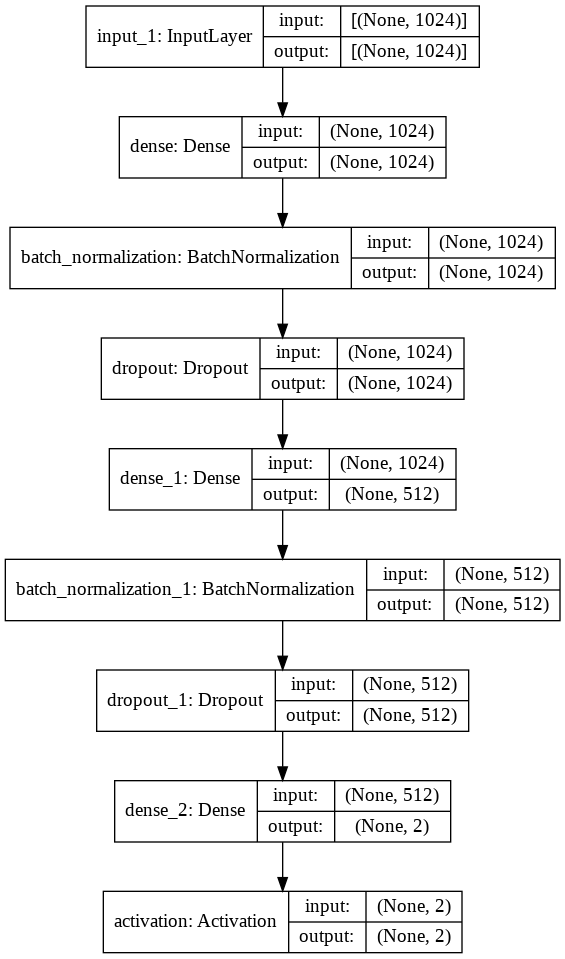

In [ ]:
lr = 0.0001
batch_size = 32
epochs = 30

ann_model = create_ANN_model(learning_rate=lr)
plot_model(ann_model, show_shapes=True)


#Training

In [ ]:
rand_forest_regr.fit(X_train[predictors], y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.3min finished


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=8,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=10, n_jobs=-1,
                                       

In [ ]:
history = ann_model.fit(X_train[predictors], y_train, validation_data=(X_test[predictors], y_test),
          epochs=epochs, batch_size=batch_size)

Epoch 1/30
6253/6253 [==============================] - 38s 4ms/step - loss: 0.5671 - acc: 0.6813 - val_loss: 0.0102 - val_acc: 0.9727
Epoch 2/30
6253/6253 [==============================] - 22s 4ms/step - loss: 0.0470 - acc: 0.9416 - val_loss: 0.0065 - val_acc: 0.9847
Epoch 3/30
6253/6253 [==============================] - 22s 3ms/step - loss: 0.0076 - acc: 0.9804 - val_loss: 0.0054 - val_acc: 0.9879
Epoch 4/30
6253/6253 [==============================] - 23s 4ms/step - loss: 0.0049 - acc: 0.9859 - val_loss: 0.0046 - val_acc: 0.9894
Epoch 5/30
6253/6253 [==============================] - 22s 4ms/step - loss: 0.0046 - acc: 0.9864 - val_loss: 0.0069 - val_acc: 0.9874
Epoch 6/30
6253/6253 [==============================] - 22s 3ms/step - loss: 0.0044 - acc: 0.9868 - val_loss: 0.0069 - val_acc: 0.9890
Epoch 7/30
6253/6253 [==============================] - 23s 4ms/step - loss: 0.0042 - acc: 0.9875 - val_loss: 0.0060 - val_acc: 0.9882
Epoch 8/30
6253/6253 [==============================] -

##Learning process

#Evaluation

In [ ]:
from sklearn.metrics import r2_score
# Predict on the new data
y_hat_rand_forest_regr = rand_forest_regr.predict(X_test[predictors])
r_squared_rand_forest_regr = rand_forest_regr.score(X_test[predictors], y_test)
print(r_squared_rand_forest_regr)
print(r2_score(y_test, y_hat_rand_forest_regr))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


0.5214351370100476
0.5214351370100476


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


In [ ]:
y_hat_ann_model = ann_model.predict(X_test[predictors])
r_squared_ann_model = r2_score(y_test, y_hat_ann_model)
print(r_squared_ann_model)

0.1681877563186548


In [ ]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.2,1))

# Plot the results
def plot_RP(first_x, first_y, first_color, first_alpha, second_x, second_y, second_color, second_alpha, score):
  plt.figure(figsize=(15,10))

  s = 50
  
  plt.scatter(first_x, first_y, edgecolor='k',
              c=first_color,cmap="spring", s=s, marker="s", alpha=first_alpha, label="Data")
  clb = plt.colorbar()

  plt.scatter(second_x, second_y, edgecolor='k',
              c=second_color,cmap="spring", s=s, alpha=second_alpha,
              label="Multi RF R-squared score=%.2f" % score)
  
  # clb = plt.colorbar()
  # clb.set_label('label', labelpad=-40, y=1.05, rotation=0)
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.xlabel("target 1")
  plt.ylabel("target 2")
  plt.title("Comparing the multi-output random forests predictions to the real labels")
  plt.legend(loc="upper left")
  
  # clb.set_label('label', labelpad=-40, y=1.05, rotation=0)

  plt.show()


In [ ]:

def plot_RP_sns(df, first_x, first_y, first_color, first_sizes, second_x, second_y, second_color, second_sizes, title):
  sns.set(style="whitegrid")
  plt.figure(figsize=(12, 8))
  sns.scatterplot(
      x=first_x, y=first_y, 
      hue=first_color, palette=sns.color_palette("muted", len(df[first_color].unique())),
      size =first_sizes ,sizes=(40, 400), marker="s",
      data=df, legend="auto",
  )
  sns.scatterplot(
      x=second_x, y=second_y,
      hue=second_color, palette=sns.color_palette("muted", len(df[second_color].unique())),
      size =second_sizes, sizes=(40, 400),marker="o",
      data=df, legend=False,
  )
  plt.scatter(
      x=[centroid_0[0], centroid_1[0], centroid_2[0]], y=[centroid_0[1], centroid_1[1], centroid_2[1]],
      c=["royalblue","orange","limegreen"], edgecolor='k',
      #hue=[0,1,2], palette=sns.color_palette("muted", 3),
      s=50,marker="X"
  )
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.legend(loc='best')
  plt.title(title)
  plt.show()

# plot_RP_sns(test,test2)

In [ ]:
def plot_RP_sns_3D(df, first_x, first_y, first_z, first_color, first_sizes, second_x, second_y, second_z, second_color, second_sizes, title):
    ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
    ax.scatter(
        xs=df[first_x], ys=df[first_y], zs=[0 for i in range(len(df[first_x]))],
        c=df[first_color], # label=df[labels],
        alpha=0.95, cmap='Accent', marker="s",
    )
    ax.scatter(
        xs=df[second_x], ys=df[second_y], zs=df[second_z],
        c=df[second_color], # label=df[labels],
        alpha=0.95, cmap='Accent', marker="o",
    )
    ax.scatter(
        xs=[centroid_0[0], centroid_1[0], centroid_2[0]], ys=[centroid_0[1], centroid_1[1], centroid_2[1]], zs=[0, 0, 0],
        edgecolor='k', c=[0,1,2], s=50, # label=df[labels],
        alpha=0.95, cmap='Accent', marker="X",
    )
    # c=label_0_df["label"],
    # alpha=label_0_df["type_num"],
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('dosage')
    # ax.set_zlim3d(0,0.5)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

Multioutput Random Forest Regression preditiction for all the data 



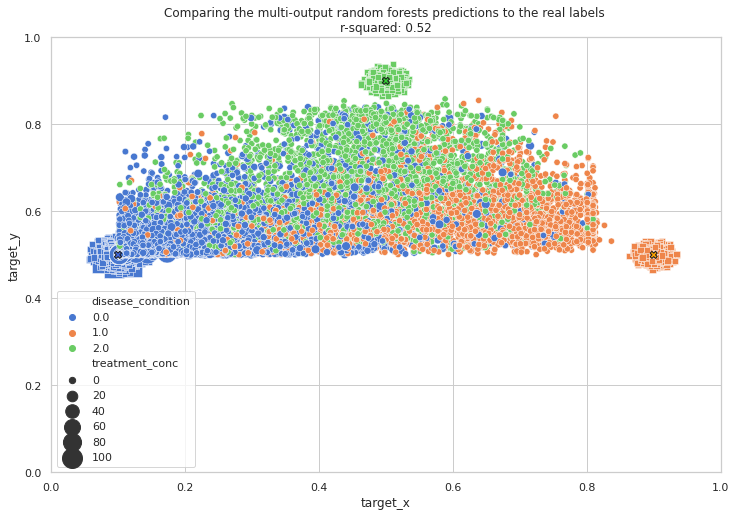

In [ ]:
rand_forest_regr_title = f"Comparing the multi-output random forests predictions to the real labels \nr-squared: %.2f" %r_squared_rand_forest_regr

y_hat_rand_forest_regr_df = pd.DataFrame({"target_x_hat":y_hat_rand_forest_regr[:,0], "target_y_hat":y_hat_rand_forest_regr[:,1]}, index=X_test.index)
rand_forest_regr_test_df = pd.concat([X_test,y_test,y_hat_rand_forest_regr_df], axis=1)

plot_RP_sns(df=rand_forest_regr_test_df, title=rand_forest_regr_title, first_x='target_x', first_y="target_y", first_color='disease_condition', first_sizes="treatment_conc", second_x='target_x_hat', second_y="target_y_hat", second_color='disease_condition', second_sizes="treatment_conc")

In [ ]:
# a = scaler.fit_transform(np.asarray(X_test.treatment_conc).reshape(-1, 1))

# plot_RP(first_x=y_test.target_x, first_y=y_test.target_y, first_color=X_test.disease_condition, first_alpha=a,second_x =y_hat_rand_forest_regr[:, 0], second_y=y_hat_rand_forest_regr[:, 1], second_color=X_test.disease_condition, second_alpha=a, score=r_squared_rand_forest_regr)

ANN preditiction for all the data 


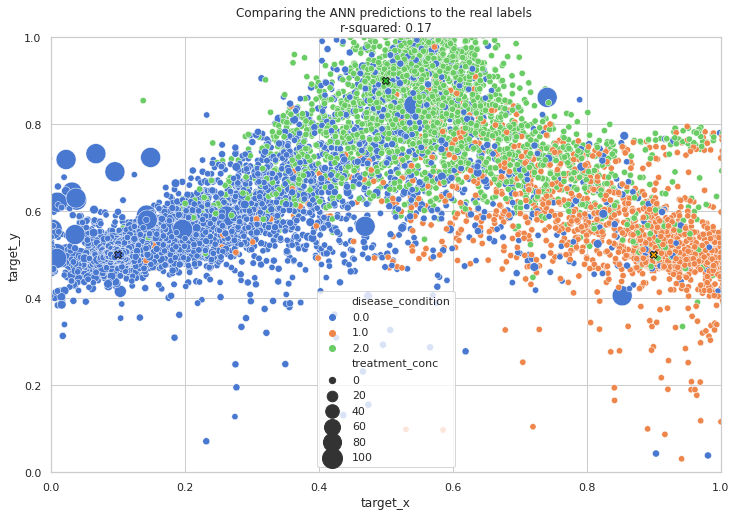

In [ ]:
ann_model_title = f"Comparing the ANN predictions to the real labels \nr-squared: %.2f" %r_squared_ann_model

y_hat_ann_model_df = pd.DataFrame({"target_x_hat":y_hat_ann_model[:,0], "target_y_hat":y_hat_ann_model[:,1]}, index=X_test.index)
ann_model_test_df = pd.concat([X_test,y_test,y_hat_ann_model_df], axis=1)

plot_RP_sns(df=ann_model_test_df, title=ann_model_title, first_x='target_x', first_y="target_y", first_color='disease_condition', first_sizes="treatment_conc", second_x='target_x_hat', second_y="target_y_hat", second_color='disease_condition', second_sizes="treatment_conc")

In [ ]:
def get_treatmet_df(treatmet_name, model, x_df, y_df, predictors):
  X_test_treatment = x_df[x_df["treatment"] == treatmet_name]
  y_test_treatment = y_df.loc[X_test_treatment.index]
  
  y_hat_model_treatment = model.predict(X_test_treatment[predictors])
  y_hat_df = pd.DataFrame({"target_x_hat":y_hat_model_treatment[:,0], "target_y_hat":y_hat_model_treatment[:,1]}, index=X_test_treatment.index)
  
  treatment_df = pd.concat([X_test_treatment,y_test_treatment,y_hat_df], axis=1)
  return treatment_df

#Experiments

selecting a single treatment and visualizing trajectory based on dosage

In [ ]:
 
 
 def plot_treatment_dosage_RP_mapping(treatmet_name, treatment_df):
  
  # treatment_df = get_treatmet_df(treatmet_name, model, x_df, y_df, predictors)

  # r_squared_treatment = r2_score(treatment_df[["target_x","target_y"]], treatment_df[["target_x_hat","target_y_hat"]])

  test_title = f"Comparing the model's predictions on the {treatmet_name} treatment to the real labels \n#samples: {len(treatment_df)}"#, r-squared: %.2f" %r_squared_treatment

  plot_RP_sns(df=treatment_df, title=test_title, first_x='target_x', first_y="target_y", first_color='disease_condition', first_sizes="treatment_conc", second_x='target_x_hat', second_y="target_y_hat", second_color='disease_condition', second_sizes="treatment_conc")
  plot_RP_sns_3D(df=treatment_df, title=test_title, first_x='target_x', first_y="target_y", first_z="treatment_conc",first_color='disease_condition', first_sizes="treatment_conc", second_x='target_x_hat', second_y="target_y_hat",second_z="treatment_conc", second_color='disease_condition', second_sizes="treatment_conc")

###Remdesivir

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


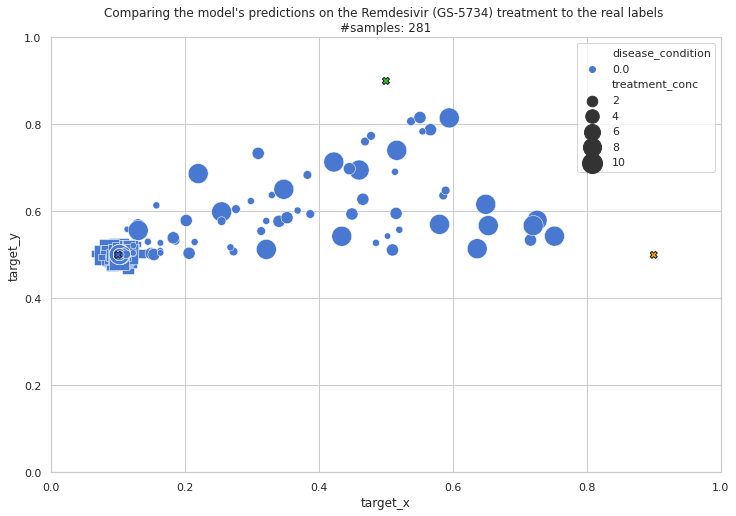

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  
No handles with labels found to put in legend.


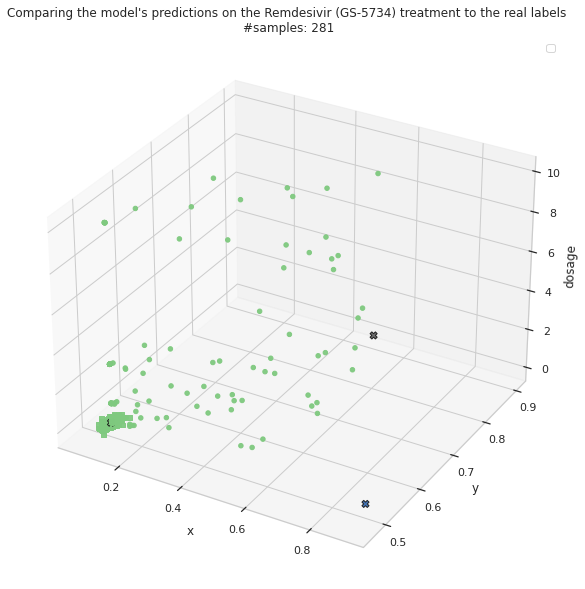

In [ ]:
remdesivir_df = get_treatmet_df("Remdesivir (GS-5734)", model=rand_forest_regr, x_df=X_test, y_df=y_test, predictors=predictors)
plot_treatment_dosage_RP_mapping(treatmet_name="Remdesivir (GS-5734)", treatment_df=remdesivir_df ) 

###polyfit1

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LinearRegression
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# np.random.seed(0)
# # set dimension of the data
# dim =  len(remdesivir_df)
# # create random data, which will be the target values
# z1 = np.asarray(remdesivir_df["treatment_conc"].tolist()).reshape(dim,1)
# z2 = z1.reshape(1,dim)
# Z = (np.ones((dim,dim)) * np.arange(1,dim+1,1))**3 + np.random.rand(dim,dim) * 200 

# Z1 = np.hstack([z1 for i in range(dim)])
# Z2 = np.vstack([z2 for i in range(dim)])

# Z=Z2
# # create a 2D-mesh
# x = np.arange(1,dim+1).reshape(dim,1)
# y = np.arange(1,dim+1).reshape(1,dim)

# # x = remdesivir_df["target_x_hat"]
# # y = remdesivir_df["target_y_hat"]
# x = np.asarray(remdesivir_df["target_x_hat"].tolist()).reshape(dim,1)
# y = np.asarray(remdesivir_df["target_y_hat"].tolist()).reshape(1,dim)



# X,Y = np.meshgrid(x,y)

# # calculate polynomial features based on the input mesh
# features = {}
# features['x^0*y^0'] = np.matmul(x**0,y**0).flatten()
# features['x*y'] = np.matmul(x,y).flatten()
# features['x*y^2'] = np.matmul(x,y**2).flatten()
# features['x^2*y^0'] = np.matmul(x**2, y**0).flatten()
# features['x^2*y'] = np.matmul(x**2, y).flatten()
# features['x^3*y^2'] = np.matmul(x**3, y**2).flatten()
# features['x^3*y'] = np.matmul(x**3, y).flatten()
# features['x^0*y^3'] = np.matmul(x**0, y**3).flatten()
# dataset = pd.DataFrame(features)

# # fit a linear regression model
# reg = LinearRegression().fit(dataset.values, Z.flatten())
# # get coefficients and calculate the predictions 
# z_pred = reg.intercept_ + np.matmul(dataset.values, reg.coef_.reshape(-1,1)).reshape(dim,dim)

# # visualize the results
# fig = plt.figure(figsize = (10,10))
# ax = Axes3D(fig)
# # plot the fitted curve
# # ax.plot_wireframe(X, Y, z_pred, label = 'prediction')
# # plot the target values
# # ax.scatter(X, Y, Z, c = 'r', label = 'datapoints')

# ax.scatter(x, y, z1, c = 'r', label = 'datapoints')
# ax.plot_wireframe(x, y, z_pred, label = 'prediction')

# # ax.view_init(25, 80)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('dosage')
# plt.legend()

###polyfit2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


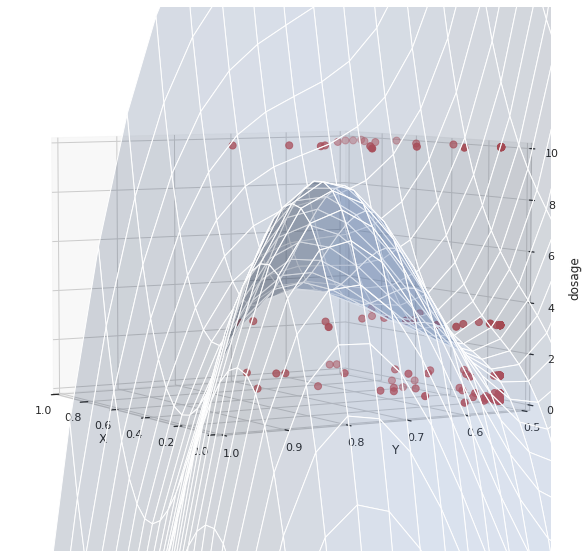

In [ ]:
# Make a 3d point cloud and fit a surface to it


import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# some 3-dim points
mean = np.array([0,0,0])
cov = np.array([[1.0,-0.2,0.8], [-0.2,1.1,0.0], [0.8,0.0,1.0]])
data = np.random.multivariate_normal(mean, cov, 90)
data[:,1] = data[:,1]**2

data = np.asarray([remdesivir_df["target_x_hat"].tolist(), remdesivir_df["target_y_hat"].tolist(), remdesivir_df["treatment_conc"].tolist()]).T


# regular grid covering the domain of the data
r=1
X,Y = np.meshgrid(np.arange(-r, r, 0.05), np.arange(-r, r*2, 0.05))
XX = X.flatten()
YY = Y.flatten()

order = 3   # 1: linear, 2: quadratic, 3: cubic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

elif order == 3:
    # best-fit cubic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2, data[:,:2]**3]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2, XX**3, YY**3], C).reshape(X.shape)


# plot points and fitted surface
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('dosage')
ax.axis('auto')
ax.axis('tight')
ax.set_xlim(0,1)
ax.set_ylim(0.5,1)
ax.set_zlim(-0,20)
ax.view_init(5, -2)

plt.show()

In [ ]:

def create_cubic_function(C):
  def cubic_func(x,y):
    return C[0] +C[1]*x + C[2]*y + C[3]*x*y + C[4]*x*x +C[5]*y*y +C[6]*x*x*x +C[7]*y*y*y
  return cubic_func

cubic_function = create_cubic_function(C)
cubic_func_pred_dosages = []
for curr_x,curr_y,_ in data:
  cubic_func_pred_dosages.append(cubic_function(curr_x,curr_y))

In [ ]:
r_squared_treatment = r2_score(data[:,2],cubic_func_pred_dosages )
r_squared_treatment

0.29382178560604033

In [ ]:
from scipy.stats import chisquare
chisquare(f_obs=data[:,2], f_exp=cubic_func_pred_dosages, ddof=1)

Power_divergenceResult(statistic=1248.732158454644, pvalue=1.6113339448165166e-122)

In [ ]:
from scipy.special import rel_entr,kl_div
# print(kl_divergence(diabetes_p, diabetes_bb_y[:len(diabetes_p)]))
kl_results = rel_entr(data[:,2], cubic_func_pred_dosages)
print(np.sum([x for x in kl_results if x <= 10000]))
# np.asarray(diabetes_bb_y).shape

362.8000861425469


###GS-441524

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


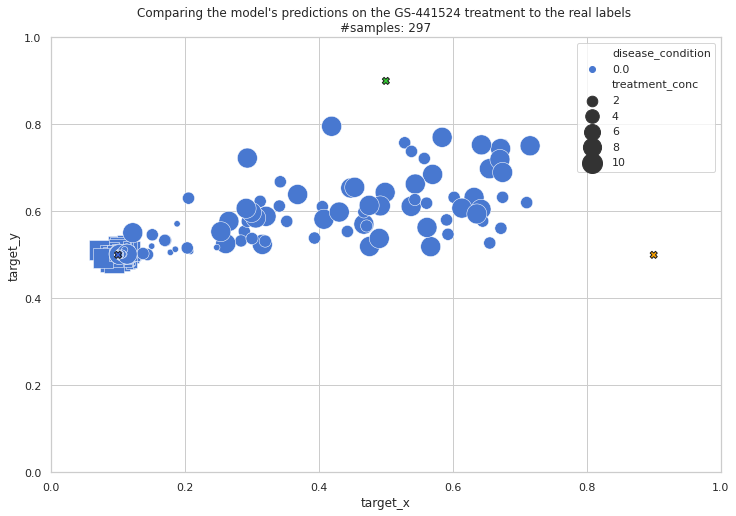

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  
No handles with labels found to put in legend.


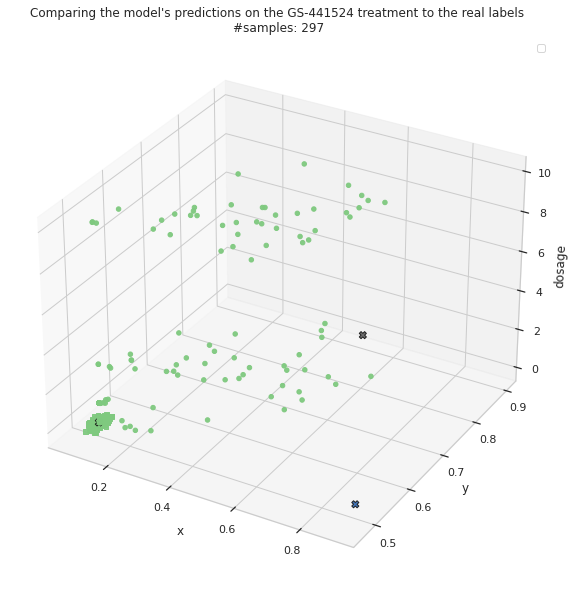

In [ ]:
gs44_df = get_treatmet_df("GS-441524", model=rand_forest_regr, x_df=X_test, y_df=y_test, predictors=predictors)
plot_treatment_dosage_RP_mapping(treatmet_name="GS-441524", treatment_df=gs44_df)

### Hydroxychloroquine Sulfate

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


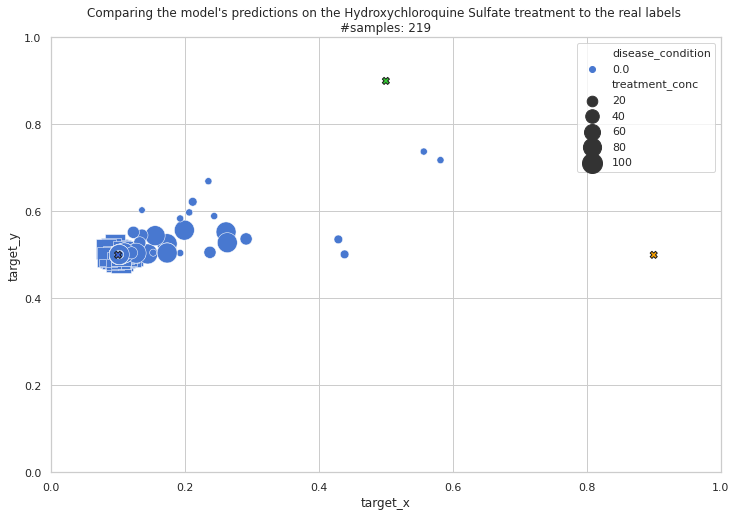

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  
No handles with labels found to put in legend.


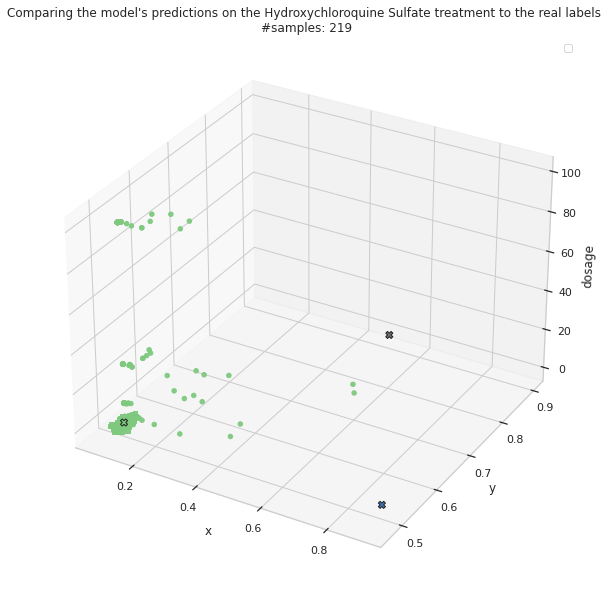

In [ ]:
hydroxychlor_df = get_treatmet_df("Hydroxychloroquine Sulfate", model=rand_forest_regr, x_df=X_test, y_df=y_test, predictors=predictors)

plot_treatment_dosage_RP_mapping(treatmet_name="Hydroxychloroquine Sulfate",  treatment_df=hydroxychlor_df)  

### Chloroquine

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


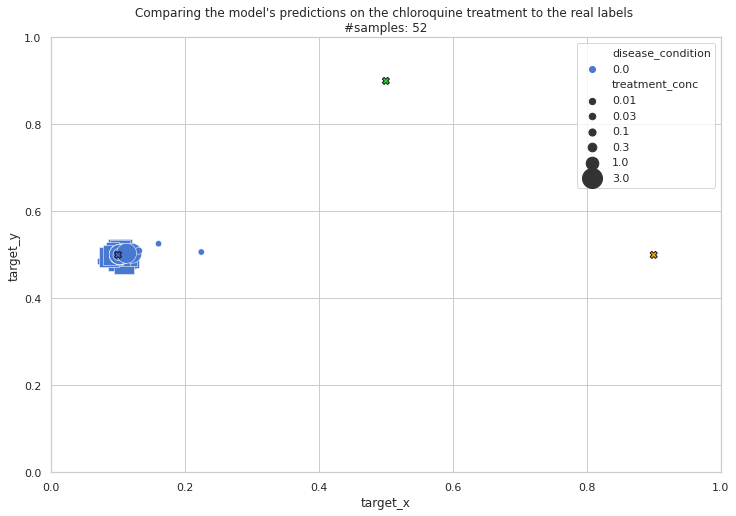

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  
No handles with labels found to put in legend.


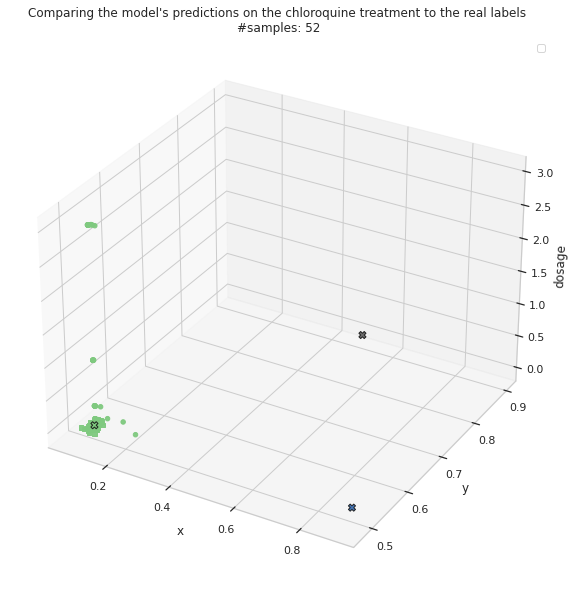

In [ ]:
chlor_df = get_treatmet_df("chloroquine", model=rand_forest_regr, x_df=X_test, y_df=y_test, predictors=predictors)

plot_treatment_dosage_RP_mapping(treatmet_name="chloroquine", treatment_df=chlor_df)

#Effiectivness Measure of treatments

In [ ]:
def cosine_similarity(u, v):
  """
  Cosine similarity reflects the degree of similarity between u and v
  Arguments:
      u -- a word embedding vector of shape (n,)          
      v -- a word embedding vector of shape (n,)

  Returns:
      cosine_similarity -- the cosine similarity between u and v defined by the formula above.
  """
  # Compute the dot product between u and v 
  dot = np.dot(u,v)
  # Compute the L2 norm of u
  norm_u = np.linalg.norm(u) 
  # Compute the L2 norm of v 
  norm_v = np.linalg.norm(v) 
  # Compute the cosine similarity
  cosine_similarity = dot / (norm_u * norm_v)
  
  return cosine_similarity

def refer_point_cos_sim_mean(samples, reference_point):
  similarities = []
  for sample in samples:
    similarities.append(cosine_similarity(sample,reference_point))
  return np.mean(similarities)

def refer_point_euclidian_dist_mean(samples, reference_point):
  dist = []
  for sample in samples:
    dist.append(np.linalg.norm(sample-reference_point))
  return np.mean(dist)

def refer_point_direction_mean(samples, reference_point):
  directions = []
  for sample in samples:
    directions.append(sample-reference_point)
  return np.mean(directions, axis=0)

In [ ]:
refer_point_direction_mean(np.asarray([(0,1),(0.5,1)]),reference_point=(1,1))

array([-0.75,  0.  ])

In [ ]:
# centroid_0 = (0.1,0.5) #Active
# centroid_1 = (0.9,0.5) #Mock
# centroid_2 = (0.5,0.9) #Inactivated

In [ ]:
def get_refer_cos_sim(centroid, centroid_name, treatment_df, treatment_name, print_sim=True):
  cossim_original= refer_point_cos_sim_mean(np.asarray(treatment_df[["target_x","target_y"]]), centroid)
  cossim_pred =refer_point_cos_sim_mean(np.asarray(treatment_df[["target_x_hat","target_y_hat"]]), centroid)
  if print_sim:
    print(f"treatment: {treatment_name}")
    print(f"cos-sim to {centroid_name} centroid of ORIGINAL labels:",cossim_original)
    print(f"cos-sim to {centroid_name} centroid of PREDICTED values:",cossim_pred)
  return cossim_original, cossim_pred

def get_refer_euclidian_dist(centroid, centroid_name, treatment_df, treatment_name, print_dist=True):
  euc_dist_original= refer_point_euclidian_dist_mean(np.asarray(treatment_df[["target_x","target_y"]]), centroid)
  euc_dist_pred =refer_point_euclidian_dist_mean(np.asarray(treatment_df[["target_x_hat","target_y_hat"]]), centroid)
  if print_dist:
    print(f"treatment: {treatment_name}")
    print(f"euc_dist to {centroid_name} centroid of ORIGINAL labels:",euc_dist_original)
    print(f"euc_dist to {centroid_name} centroid of PREDICTED values:",euc_dist_pred)
  return euc_dist_original, euc_dist_pred

def get_refer_direction(centroid, centroid_name, treatment_df, treatment_name, print_direction=True):
  direction_original= refer_point_direction_mean(np.asarray(treatment_df[["target_x","target_y"]]), centroid)
  direction_pred =refer_point_direction_mean(np.asarray(treatment_df[["target_x_hat","target_y_hat"]]), centroid)
  if print_direction:
    print(f"treatment: {treatment_name}")
    print(f"direction to {centroid_name} centroid of ORIGINAL labels:",direction_original)
    print(f"direction to {centroid_name} centroid of PREDICTED values:",direction_pred)
  return direction_original, direction_pred

In [ ]:
cossim_original_remdesivir_0, cossim_pred_remdesivir_0 = get_refer_cos_sim(centroid_0, "Active", remdesivir_df, "Remdesivir (GS-5734)")
cossim_original_remdesivir_1, cossim_pred_remdesivir_1 = get_refer_cos_sim(centroid_1, "Mock", remdesivir_df, "Remdesivir (GS-5734)")
cossim_original_remdesivir_2, cossim_pred_remdesivir_2 = get_refer_cos_sim(centroid_2, "Inactivated", remdesivir_df, "Remdesivir (GS-5734)")
print(cossim_pred_remdesivir_0/cossim_original_remdesivir_0)
print(cossim_pred_remdesivir_1/cossim_original_remdesivir_1)
print(cossim_pred_remdesivir_2/cossim_original_remdesivir_2)

treatment: Remdesivir (GS-5734)
cos-sim to Active centroid of ORIGINAL labels: 0.9998082461170893
cos-sim to Active centroid of PREDICTED values: 0.9825175423697878
treatment: Remdesivir (GS-5734)
cos-sim to Mock centroid of ORIGINAL labels: 0.6474034734835802
cos-sim to Mock centroid of PREDICTED values: 0.6973135333328758
treatment: Remdesivir (GS-5734)
cos-sim to Inactivated centroid of ORIGINAL labels: 0.9521932131658626
cos-sim to Inactivated centroid of PREDICTED values: 0.9601684721202929
0.9827059800572234
1.0770926661556774
1.0083756729665339


In [ ]:
cossim_original_chlor_0, cossim_pred_chlor_0 = get_refer_cos_sim(centroid_0, "Active", chlor_df, "chloroquine")
cossim_original_chlor_1, cossim_pred_chlor_1 = get_refer_cos_sim(centroid_1, "Mock", chlor_df, "chloroquine")
cossim_original_chlor_2, cossim_pred_chlor_2 = get_refer_cos_sim(centroid_2, "Inactivated", chlor_df, "chloroquine")
print(cossim_pred_chlor_0/cossim_original_chlor_0)
print(cossim_pred_chlor_1/cossim_original_chlor_1)
print(cossim_pred_chlor_2/cossim_original_chlor_2)

treatment: chloroquine
cos-sim to Active centroid of ORIGINAL labels: 0.9998107715289108
cos-sim to Active centroid of PREDICTED values: 0.9993552912155171
treatment: chloroquine
cos-sim to Mock centroid of ORIGINAL labels: 0.645834648969309
cos-sim to Mock centroid of PREDICTED values: 0.6582150904794997
treatment: chloroquine
cos-sim to Inactivated centroid of ORIGINAL labels: 0.951567434391764
cos-sim to Inactivated centroid of PREDICTED values: 0.956203796988932
0.9995444334804503
1.0191696768359342
1.0048723426523434


Analysis of all the treatments

In [ ]:
def plot_treatments_bars(metric_name, dataframe, n):
  labels = dataframe["treatment"].unique()[:n]
  x = np.arange(len(labels))  # the label locations
  width = 0.2  # the width of the bars
  fig, ax = plt.subplots()
  fig.set_figheight(5)
  fig.set_figwidth(25)
  rects1 = ax.bar(x - width, dataframe[f"{metric_name}_0"].head(n), width, label=f"{metric_name} - centroid 0" )
  rects2 = ax.bar(x, dataframe[f"{metric_name}_1"].head(n), width, label=f"{metric_name} - centroid 1")
  rects3 = ax.bar(x + width, dataframe[f"{metric_name}_2"].head(n), width, label=f"{metric_name} - centroid 2")

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Scores')
  ax.set_title(f"{metric_name} by treatments and centroids")
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  ax.bar_label(rects1, padding=3)
  ax.bar_label(rects2, padding=3)
  ax.bar_label(rects3, padding=3)

  # fig.tight_layout()
  ax.autoscale(tight=True)

  plt.show()

In [ ]:
def plot_treatments_bars_by_centroid(centroid_number, metric_name, dataframe, n):
  labels = dataframe["treatment"].unique()[:n]
  x = np.arange(len(labels))  # the label locations
  width = 0.2  # the width of the bars

  fig, ax = plt.subplots()
  fig.set_figheight(4)
  fig.set_figwidth(10)
  rects1 = ax.bar(x, dataframe[f"{metric_name}_{centroid_number}"].head(n), width, label=f"{metric_name} - centroid {centroid_number}")

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Scores')
  ax.set_title(f'{metric_name} to centroid {centroid_number} by treatments')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  ax.bar_label(rects1, padding=3)

  # ax.autoscale(tight=True)
  plt.show()



Cosine Similarity

In [ ]:
cossim_df = pd.DataFrame()
for treatment_name in X_test["treatment"].unique():
  treatment_df = get_treatmet_df(treatment_name, model=rand_forest_regr, x_df=X_test, y_df=y_test, predictors=predictors)
  cossim_original_0, cossim_pred_0 = get_refer_cos_sim(centroid_0, "Active", treatment_df, treatment_name, False)
  cossim_original_1, cossim_pred_1 = get_refer_cos_sim(centroid_1, "Mock", treatment_df, treatment_name, False)
  cossim_original_2, cossim_pred_2 = get_refer_cos_sim(centroid_2, "Inactivated", treatment_df, treatment_name, False)
  cossim_df = cossim_df.append({"treatment": treatment_name, "cossim_original_0": cossim_original_0, "cossim_pred_0": cossim_pred_0, "cossim_ratio_0": cossim_pred_0/cossim_original_0, "cossim_original_1": cossim_original_1, "cossim_pred_1": cossim_pred_1,"cossim_ratio_1": cossim_pred_1/cossim_original_1, "cossim_original_2": cossim_original_2, "cossim_pred_2": cossim_pred_2,"cossim_ratio_2": cossim_pred_2/cossim_original_2}, ignore_index=True)

Streaming output truncated to the last 5000 lines.
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBack

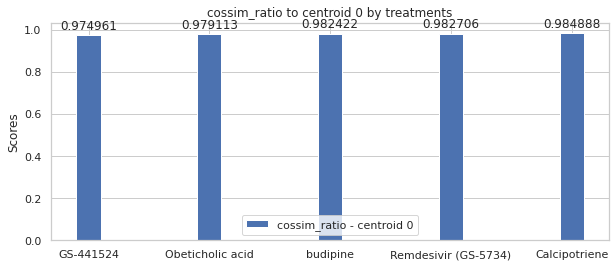

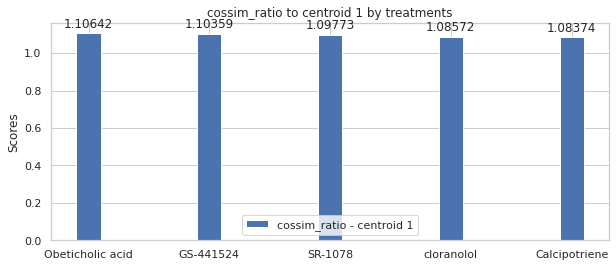

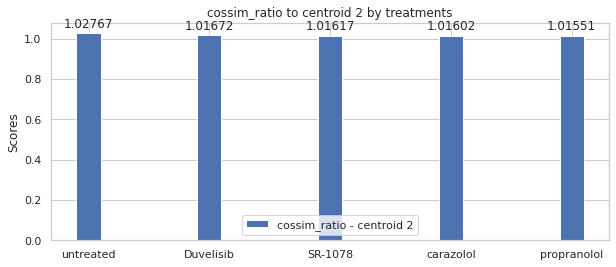

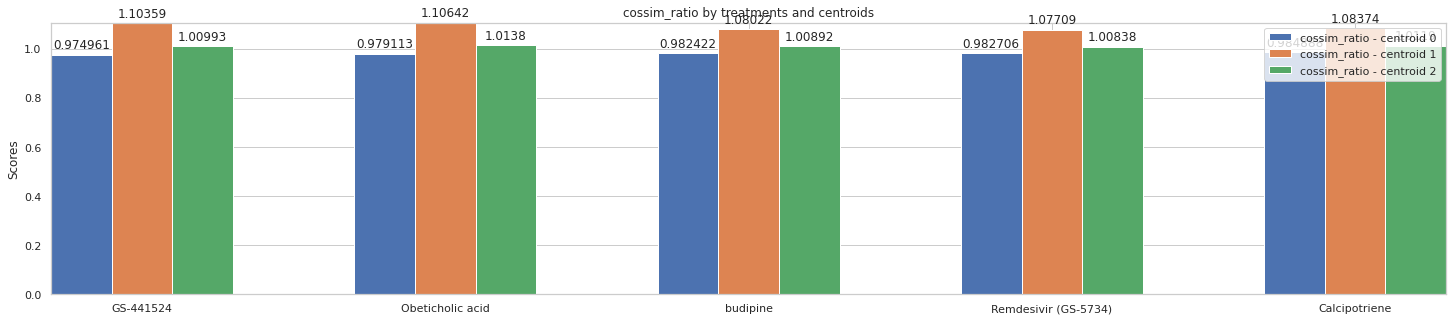

In [ ]:
# cossim to centroid 0 - cossim to sick state - smaller is better
cossim_df = cossim_df.sort_values("cossim_ratio_0", ascending=True)
plot_treatments_bars_by_centroid(0, "cossim_ratio", cossim_df, 5)

# cossim to centroid 1 - cossim to Mock state - bigger is better
cossim_df = cossim_df.sort_values("cossim_ratio_1", ascending=False)
plot_treatments_bars_by_centroid(1, "cossim_ratio", cossim_df, 5)

# cossim to centroid 2 - cossim to iraddiated state - bigger is better
cossim_df = cossim_df.sort_values("cossim_ratio_2", ascending=False)
plot_treatments_bars_by_centroid(2, "cossim_ratio", cossim_df, 5)

#sorting by cossim to centroid 1, then by centroid 2, and then by centroid 3
cossim_df = cossim_df.sort_values(["cossim_ratio_0","cossim_ratio_1","cossim_ratio_2"], ascending=[True, False, False])
plot_treatments_bars("cossim_ratio", cossim_df, 5)

Euclidean Distance

In [ ]:
euc_dist_df = pd.DataFrame()
for treatment_name in X_test["treatment"].unique():
  treatment_df = get_treatmet_df(treatment_name, model=rand_forest_regr, x_df=X_test, y_df=y_test, predictors=predictors)
  euc_dist_original_0, euc_dist_pred_0 = get_refer_euclidian_dist(centroid_0, "Active", treatment_df, treatment_name, False)
  euc_dist_original_1, euc_dist_pred_1 = get_refer_euclidian_dist(centroid_1, "Mock", treatment_df, treatment_name, False)
  euc_dist_original_2, euc_dist_pred_2 = get_refer_euclidian_dist(centroid_2, "Inactivated", treatment_df, treatment_name, False)
  euc_dist_df = euc_dist_df.append({"treatment": treatment_name, "euc_dist_original_0": euc_dist_original_0, "euc_dist_pred_0": euc_dist_pred_0, "euc_dist_ratio_0": euc_dist_pred_0/euc_dist_original_0, "euc_dist_original_1": euc_dist_original_1, "euc_dist_pred_1": euc_dist_pred_1,"euc_dist_ratio_1": euc_dist_pred_1/euc_dist_original_1, "euc_dist_original_2": euc_dist_original_2, "euc_dist_pred_2": euc_dist_pred_2,"euc_dist_ratio_2": euc_dist_pred_2/euc_dist_original_2}, ignore_index=True)

In [ ]:
# distance from centroid 0 - distance from sick state - bigger is better
euc_dist_df = euc_dist_df.sort_values("euc_dist_ratio_0", ascending=False)
plot_treatments_bars_by_centroid(0, "euc_dist_ratio", euc_dist_df, 5)

# distance from centroid 1 - distance from Mock state - smaler is better
euc_dist_df = euc_dist_df.sort_values("euc_dist_ratio_1", ascending=True)
plot_treatments_bars_by_centroid(1, "euc_dist_ratio", euc_dist_df, 5)

# distance from centroid 2 - distance from iraddiated state - smaller is better
euc_dist_df = euc_dist_df.sort_values("euc_dist_ratio_2", ascending=True)
plot_treatments_bars_by_centroid(2, "euc_dist_ratio", euc_dist_df, 5)


#sorting by distance from centroid 1, then by centroid 2, and then by cntroid 3
euc_dist_df = euc_dist_df.sort_values(["euc_dist_ratio_0","euc_dist_ratio_1","euc_dist_ratio_2"], ascending=[False,True,True])
plot_treatments_bars("euc_dist_ratio", euc_dist_df, 5)

Directionality

In [ ]:
# direction_df = pd.DataFrame()
# for treatment_name in X_test["treatment"].unique():
#   treatment_df = get_treatmet_df(treatment_name, model=rand_forest_regr, x_df=X_test, y_df=y_test, predictors=predictors)
#   direction_original_0, direction_pred_0 = get_refer_direction(centroid_0, "Active", treatment_df, treatment_name, False)
#   direction_original_1, direction_pred_1 = get_refer_direction(centroid_1, "Mock", treatment_df, treatment_name, False)
#   direction_original_2, direction_pred_2 = get_refer_direction(centroid_2, "Inactivated", treatment_df, treatment_name, False)
#   direction_df = direction_df.append({"treatment": treatment_name, "direction_original_0": direction_original_0, "direction_pred_0": direction_pred_0, "direction_ratio_0": direction_pred_0/direction_original_0, "direction_original_1": direction_original_1, "direction_pred_1": direction_pred_1,"direction_ratio_1": direction_pred_1/direction_original_1, "direction_original_2": direction_original_2, "direction_pred_2": direction_pred_2,"direction_ratio_2": direction_pred_2/direction_original_2}, ignore_index=True)

In [ ]:
# # direction from centroid 0 - direction from sick state - bigger is better
# euc_dist_df = euc_dist_df.sort_values("euc_dist_ratio_0", ascending=False)
# plot_treatments_bars_by_centroid(0, "euc_dist_ratio", euc_dist_df, 20)

# # direction from centroid 1 - direction from Mock state - smaler is better
# euc_dist_df = euc_dist_df.sort_values("euc_dist_ratio_1", ascending=True)
# plot_treatments_bars_by_centroid(1, "euc_dist_ratio", euc_dist_df, 20)

# # direction from centroid 2 - direction from iraddiated state - smaller is better
# euc_dist_df = euc_dist_df.sort_values("euc_dist_ratio_2", ascending=True)
# plot_treatments_bars_by_centroid(2, "euc_dist_ratio", euc_dist_df, 20)


# #sorting by direction from centroid 1, then by centroid 2, and then by cntroid 3
# euc_dist_df = euc_dist_df.sort_values(["euc_dist_ratio_0","euc_dist_ratio_1","euc_dist_ratio_2"], ascending=[False,True,True])
# plot_treatments_bars("euc_dist_ratio", euc_dist_df, 10)